In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import sys
import numpy as np
import pandas as pd
import matplotlib

## Water Contamination Data

In [2]:
def read_file(fname, sep=','):
    df = pd.read_csv('data/{}'.format(fname), sep=sep, encoding='utf-8')
    return df

def join_zip_codes(df):
    '''Merge zip code data set into UCMR3 data set'''
    zip_codes = read_file('UCMR3_ZipCodes.csv')
    df.set_index('PWSID').join(zip_codes.set_index('PWSID'))
    df = df.merge(zip_codes, how='left')
    df = df.rename(columns={'ZIPCODE': 'Zip'})
    df = df.drop(['PWSID'], axis=1)
    #df = df.dropna()
    df['Zip']=df['Zip'].astype(str)
    return df

def join_lat_long(df):
    '''Merge lat/long data set into UCMR3 data set'''
    zip_codes = read_file('UCMR3_ZipCodes.csv')
    lat_long = read_file('us-zip-code-latitude-and-longitude.csv', sep=';')
    lat_long = lat_long.drop(['Timezone', 'Daylight savings time flag', 'geopoint', 'City', 'State'], 1)
    lat_long['Zip']=lat_long['Zip'].astype(str)
    df.set_index('Zip').join(lat_long.set_index('Zip'))
    df = df.merge(lat_long, how='left')
    return df

def transform_results_sign(df):
    '''
    Convert results sign (where < indicates levels below minimum reporting level and = indicates above)
    Drops any rows that are not classified as either < or =
    '''
    print(df.size)
    results_sign = pd.DataFrame([['<', 0], ['=', 1]], columns=['AnalyticalResultsSign', 'IsContaminated'])
    df.set_index('AnalyticalResultsSign').join(results_sign.set_index('AnalyticalResultsSign'))
    df = df.merge(results_sign, how='left')
    print(df.size)
    df = df.drop(['AnalyticalResultsSign','AnalyticalResultValue'], 1)
    return df

def convert_datetime(df):
    df['CollectionDate'] = pd.to_datetime(df['CollectionDate'])
    return df

def get_contamination_df():
    #for f in ['UCMR3_All_Tribes_AK_LA.csv', 'UCMR3_All_MA_WY.csv']:
    for f in ['UCMR3_All_Tribes_AK_LA.csv']:
        df = read_file('UCMR3_All_Tribes_AK_LA.csv')
        print(df.columns)
        print(df.AnalyticalResultsSign.unique())
        df = df[['PWSID', 'Size', 'FacilityID', 'FacilityWaterType', 'CollectionDate', 'Contaminant', 'AnalyticalResultsSign', 'AnalyticalResultValue']]
        df = join_zip_codes(df)
        df = join_lat_long(df)
        df = transform_results_sign(df)
        df = convert_datetime(df)
        return df

In [3]:
wc = get_contamination_df()

Index(['PWSID', 'PWSName', 'Size', 'FacilityID', 'FacilityName',
       'FacilityWaterType', 'SamplePointID', 'SamplePointName',
       'SamplePointType', 'AssociatedFacilityID', 'AssociatedSamplePointID',
       'CollectionDate', 'SampleID', 'Contaminant', 'MRL', 'MethodID',
       'AnalyticalResultsSign', 'AnalyticalResultValue', 'SampleEventCode',
       'MonitoringRequirement', 'Region', 'State'],
      dtype='object')
['<' '=']
31528530
34681383


We want to see how many contaminants we can expect to see in samples collected from a facility date at any point in time, and we want to see this across all facilities/collection dates.

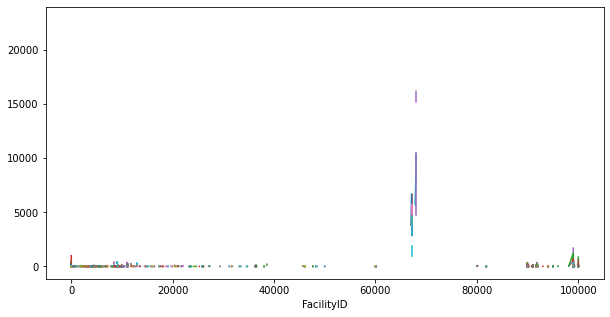

In [5]:
wc_facility_sample_ccount = wc.groupby(['FacilityID','CollectionDate'])['IsContaminated'].sum().reset_index()
wc_graph = wc_facility_sample_ccount.set_index(['CollectionDate', 'FacilityID']).IsContaminated.unstack(-2)
wc_graph.plot(legend=False)
plt.show()

We can see there are samples taken at a single facility over the course of several days (as a single color indicates a combination of facility ID & collection date). We don't want to count all contaminants detected on all days. Rather, we want count the unique contaminants across all samples taken together so that a single entry in our dataframe is indicative of a single "event". Below we see that water sampling tends to go on for as long as a month.

In [6]:
wc_facility_sample_ccount[(wc_facility_sample_ccount['FacilityID']==1) & 
                          (wc_facility_sample_ccount['CollectionDate'].dt.month==1)]

,FacilityID,CollectionDate,IsContaminated
0,1,2013-01-07,10
1,1,2013-01-10,10
2,1,2013-01-15,7
3,1,2013-01-16,17
4,1,2013-01-18,4
5,1,2013-01-22,2
6,1,2013-01-23,107
7,1,2013-01-28,79
8,1,2013-01-29,9
162,1,2014-01-07,11


Let's group together windows of 40 days, and count the number of unique contaminants seen for those groups.

In [7]:
wc_cleaned = (wc.groupby([pd.Grouper(key='CollectionDate', freq='50D'), 'FacilityID'])['Contaminant']
             .nunique()
             .reset_index()
             .rename(columns={'Contaminant':'ContaminantCount'}))
wc_cleaned.head()

,CollectionDate,FacilityID,ContaminantCount
0,2013-01-02,1,33
1,2013-01-02,2,33
2,2013-01-02,3,33
3,2013-01-02,4,33
4,2013-01-02,5,21


We see that the number of unique contaminantis somewhere between 0 and 35.

array([[<AxesSubplot:title={'center':'ContaminantCount'}>]], dtype=object)

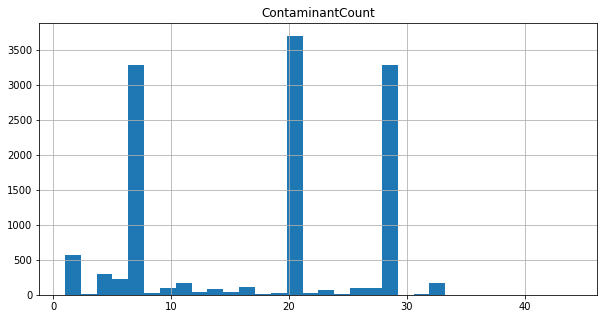

In [8]:
wc_cleaned["sampleId"] = wc_cleaned["FacilityID"].astype(str) + '_' + wc_cleaned["CollectionDate"].astype(str)
wc_graph = wc_cleaned.copy()
wc_graph = wc_graph.drop(columns=["FacilityID","CollectionDate"])
wc_graph.hist(column='ContaminantCount', bins=len(wc_graph['ContaminantCount'].unique()))

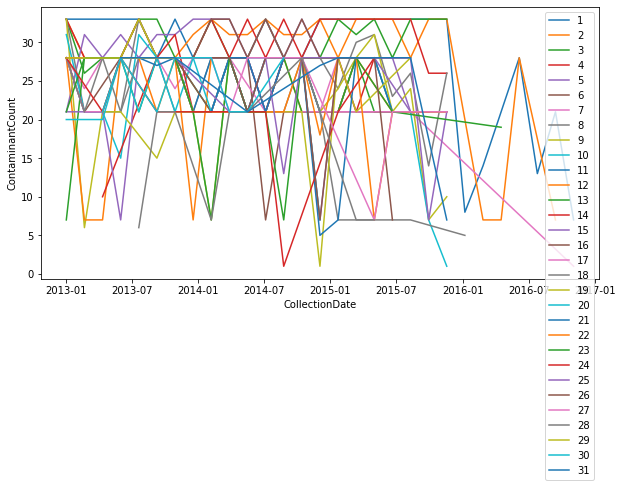

In [9]:
# Let's only plot the trend over time for a few facilities, as otherwise the plot becomes unreadable
groups = wc_cleaned.groupby("FacilityID")
for i, (name, group) in enumerate(groups):
    plt.plot(group["CollectionDate"], group["ContaminantCount"],label=name)
    if i==30: break
plt.legend()
plt.xlabel('CollectionDate')
plt.ylabel('ContaminantCount')
plt.show()

In [10]:
wc_cleaned['ContaminantCount'].describe()

count    12447.000000
mean        17.474572
std          9.302985
min          1.000000
25%          7.000000
50%         21.000000
75%         28.000000
max         44.000000
Name: ContaminantCount, dtype: float64

So now we know we have general contamination statistics per facility/collection event (of which there is a grand total of 12,447 events). We see an average of 17 contaminants per event. At max we see 44 contaminants, and the least we have seen is 1.

Next we will explore our fracking data set, after which we will look at both in conjunction - primarily, placement of fracking & facilities in terms of latitude/longitude.

## Fracking Data Set